In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm import trange

import time

import torch
import torch.nn as nn
import torch.optim as optim
from IPython import display

import os
import argparse
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from tqdm import trange

import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from utils.data_generators import generate_train_data, generate_test_data_pytorch


## 1. SPINN

In [2]:
import torch
import torch.nn as nn

class SPINN(nn.Module):
    def __init__(self, features):
        super().__init__()
        self.features = features
        
        # Создаем слои для каждого входа (t, x, y)
        self.networks = nn.ModuleList([
            self._build_network() for _ in range(3)
        ])
        
        # Добавляем слои для объединения выходов
        self.combine_layer1 = nn.Linear(features[-1] * 2, features[-1])
        self.combine_layer2 = nn.Linear(features[-1] * 2, features[-1])
        self.final_layer = nn.Linear(features[-1], 1)
        self.activation = nn.Tanh()
    
    def _build_network(self):
        layers = []
        layers.append(nn.Linear(1, self.features[0]))
        layers.append(nn.Tanh())
        
        for i in range(len(self.features) - 2):
            layers.append(nn.Linear(self.features[i], self.features[i + 1]))
            layers.append(nn.Tanh())
            
        layers.append(nn.Linear(self.features[-2], self.features[-1]))
        layers.append(nn.Tanh())
        return nn.Sequential(*layers)
    
    def _ensure_2d(self, x):
        if x.dim() == 1:
            return x.unsqueeze(1)
        return x
    
    def forward(self, t, x, y):
        # Преобразуем входы в 2D тензоры [batch_size, 1]
        t = self._ensure_2d(t)
        x = self._ensure_2d(x)
        y = self._ensure_2d(y)
        
        # Пропускаем через отдельные сети
        t_features = self.networks[0](t)
        x_features = self.networks[1](x)
        y_features = self.networks[2](y)
        
        # Объединяем признаки
        combined = torch.cat([t_features, x_features], dim=1)
        combined = self.activation(self.combine_layer1(combined))
        
        combined = torch.cat([combined, y_features], dim=1)
        combined = self.activation(self.combine_layer2(combined))
        
        # Финальный слой
        output = self.final_layer(combined)
        return output.squeeze(-1)

class SPINN_Loss:
    def __init__(self, model):
        self.model = model

    def residual_loss(self, t, x, y, a, b):
        # Убеждаемся, что входные тензоры требуют градиентов
        if not t.requires_grad:
            t.requires_grad_(True)
        if not x.requires_grad:
            x.requires_grad_(True)
        if not y.requires_grad:
            y.requires_grad_(True)
        
        # Вычисляем u
        u = self.model(t, x, y)
        
        # 1-я производная по t
        ut = torch.autograd.grad(
            u, t,
            grad_outputs=torch.ones_like(u),
            create_graph=True,
            retain_graph=True
        )[0]
        
        # 1-я производная по x
        ux = torch.autograd.grad(
            u, x,
            grad_outputs=torch.ones_like(u),
            create_graph=True,
            retain_graph=True
        )[0]
        
        # 1-я производная по y
        uy = torch.autograd.grad(
            u, y,
            grad_outputs=torch.ones_like(u),
            create_graph=True,
            retain_graph=True
        )[0]
        
        # Остаток уравнения: u_t + a*u_x + b*u_y = 0
        residual = ut + a*ux + b*uy
        return torch.mean(residual**2)

    def initial_loss(self, t, x, y, u_true):
        u_pred = self.model(t, x, y)
        return torch.mean((u_pred - u_true)**2)

    def boundary_loss(self, t, x, y, u_true):
        loss = 0.
        for i in range(len(t)):
            u_pred = self.model(t[i], x[i], y[i])
            loss += torch.mean((u_pred - u_true[i])**2)
        return loss / len(t)

    def __call__(self, *train_data):
        # Распаковываем данные
        tc, xc, yc, ti, xi, yi, ui, tb, xb, yb, ub, a, b = train_data
        
        # Вычисляем функцию потерь
        loss_residual = self.residual_loss(tc, xc, yc, a, b)
        loss_initial = self.initial_loss(ti, xi, yi, ui)
        loss_boundary = self.boundary_loss(tb, xb, yb, ub)
        
        total_loss = loss_residual + loss_initial + loss_boundary
        
        return total_loss, (loss_residual, loss_initial, loss_boundary)

# Функция шага оптимизации
def update_model(model, optimizer, loss_fn, train_data):
    optimizer.zero_grad()
    loss, (loss_residual, loss_initial, loss_boundary) = loss_fn(*train_data)
    loss.backward()
    optimizer.step()
    return loss.item(), loss_residual.item(), loss_initial.item(), loss_boundary.item()

## 2. Data generator

In [3]:
# Точное решение уравнения переноса (Flow Mixing)
def _flow_mixing3d_exact_u(t, x, y, a=1.0, b=1.0):
    return torch.sin(np.pi * (x - a*t)) * torch.sin(np.pi * (y - b*t))

# Генератор тренировочных данных для Flow Mixing
def spinn_train_generator_flow_mixing3d(nc, a=1.0, b=1.0, seed=None):
    if seed is not None:
        torch.manual_seed(seed)
    
    # Точки коллокации
    tc = torch.rand(nc) * 1.0
    xc = torch.rand(nc) * 1.0
    yc = torch.rand(nc) * 1.0
    
    # Начальные точки (t=0)
    ti = torch.zeros(nc)
    xi = torch.rand(nc) * 1.0
    yi = torch.rand(nc) * 1.0
    ui = _flow_mixing3d_exact_u(ti, xi, yi, a, b)
    
    # Граничные точки
    tb = [tc] * 4
    xb = [torch.full_like(tc, 0.0),
          torch.full_like(tc, 1.0),
          xc,
          xc]
    yb = [yc,
          yc,
          torch.full_like(tc, 0.0),
          torch.full_like(tc, 1.0)]
    
    ub = [_flow_mixing3d_exact_u(tb[i], xb[i], yb[i], a, b) for i in range(4)]
    
    return tc, xc, yc, ti, xi, yi, ui, tb, xb, yb, ub, a, b

# Генератор тестовых данных для Flow Mixing
def spinn_test_generator_flow_mixing3d(nc_test, a=1.0, b=1.0):
    t = torch.linspace(0, 1, nc_test)
    x = torch.linspace(0, 1, nc_test)
    y = torch.linspace(0, 1, nc_test)
    
    tm, xm, ym = torch.meshgrid(t, x, y, indexing='ij')
    u_gt = _flow_mixing3d_exact_u(tm, xm, ym, a, b)
    
    return t, x, y, u_gt, tm, xm, ym, a, b

# Функция для визуализации результатов
def plot_flow_mixing_results(t_idx, t, x, y, u_gt, u_pred):
    """
    Визуализация результатов для уравнения переноса (Flow Mixing)
    
    Параметры:
    ----------
    t_idx : int
        Индекс временного слоя для визуализации
    t, x, y : torch.Tensor
        Координатные сетки
    u_gt : torch.Tensor
        Точное решение
    u_pred : torch.Tensor
        Предсказанное решение
    """
    
    fig = plt.figure(figsize=(18, 6))
    
    # Точное решение
    ax1 = fig.add_subplot(131, projection='3d')
    X, Y = torch.meshgrid(x, y, indexing='ij')
    surf1 = ax1.plot_surface(X.numpy(), Y.numpy(), u_gt[t_idx].numpy(), 
                            cmap=cm.viridis, linewidth=0, antialiased=False)
    ax1.set_title(f'Точное решение (t={t[t_idx].item():.2f})')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_zlabel('u')
    
    # Предсказанное решение
    ax2 = fig.add_subplot(132, projection='3d')
    surf2 = ax2.plot_surface(X.numpy(), Y.numpy(), u_pred[t_idx].numpy(), 
                            cmap=cm.viridis, linewidth=0, antialiased=False)
    ax2.set_title(f'Предсказанное решение (t={t[t_idx].item():.2f})')
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_zlabel('u')
    
    # Абсолютная ошибка
    ax3 = fig.add_subplot(133, projection='3d')
    error = torch.abs(u_gt[t_idx] - u_pred[t_idx])
    surf3 = ax3.plot_surface(X.numpy(), Y.numpy(), error.numpy(), 
                            cmap=cm.viridis, linewidth=0, antialiased=False)
    ax3.set_title(f'Абсолютная ошибка (t={t[t_idx].item():.2f})')
    ax3.set_xlabel('x')
    ax3.set_ylabel('y')
    ax3.set_zlabel('|u_gt - u_pred|')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Максимальная ошибка: {error.max().item():.6f}")
    print(f"Средняя ошибка: {error.mean().item():.6f}")


## 3. Utils

In [4]:
def relative_l2(u, u_gt):
    return torch.norm(u - u_gt) / torch.norm(u_gt)

def plot_flow_mixing3d(t, x, y, u):
    # Преобразуем тензоры PyTorch в numpy массивы для визуализации
    t = t.detach().cpu().numpy().flatten()
    x = x.detach().cpu().numpy().flatten()
    y = y.detach().cpu().numpy().flatten()
    u = u.detach().cpu().numpy().flatten()
    
    # Нормализуем значения для цветовой карты
    u_norm = (u - u.min()) / (u.max() - u.min())
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Создаем scatter plot с нормализованными цветами
    scatter = ax.scatter(t, x, y, c=u_norm, s=1, cmap='viridis', vmin=0, vmax=1)
    
    # Настраиваем внешний вид
    ax.set_title('Смешивание потока в 3D (Flow Mixing)', fontsize=20)
    ax.set_xlabel('t', fontsize=18, labelpad=10)
    ax.set_ylabel('x', fontsize=18, labelpad=10)
    ax.set_zlabel('y', fontsize=18, labelpad=10)
    
    # Добавляем colorbar с реальными значениями
    cbar = plt.colorbar(scatter)
    cbar.set_label('Концентрация u(t,x,y)', fontsize=16)
    
    plt.show()
    # Сохраняем результат
    # plt.savefig('klein_gordon3d.png', dpi=300, bbox_inches='tight')
    # plt.close()

## 4. Main function

In [5]:
def main(NC, NI, NB, NC_TEST, SEED, LR, EPOCHS, N_LAYERS, FEATURES, LOG_ITER, VMAX=0.385):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    torch.manual_seed(SEED)
    
    feat_sizes = [FEATURES] * N_LAYERS
    model = SPINN(feat_sizes).to(device)
    optimizer = optim.Adam(model.parameters(), lr=LR)
    
    # Списки для хранения значений лоссов
    loss_history = []
    residual_loss_history = []
    initial_loss_history = []
    boundary_loss_history = []
    error_history = []
    
    # Настраиваем аргументы для генерации данных
    args = argparse.Namespace(
        nc=NC,
        nc_test=NC_TEST,
        vmax=VMAX,
        seed=SEED,
        equation='flow_mixing3d'
    )
    
    # Используем существующие функции для генерации данных
    train_data = generate_train_data(args)
    train_data = [t.to(device) if isinstance(t, torch.Tensor) else 
                 [tensor.to(device) for tensor in t] if isinstance(t, list) else t 
                 for t in train_data]
    
    # Генерируем тестовые данные
    test_dir = os.path.join(os.getcwd(), 'temp_test_results')
    os.makedirs(test_dir, exist_ok=True)
    test_data = generate_test_data_pytorch(args, test_dir)
    test_data = [t.to(device) if isinstance(t, torch.Tensor) else t for t in test_data]
    
    # Распаковываем тестовые данные правильно
    t, x, y, T, X, Y = test_data
    
    # Создаем сетки
    tm, xm, ym = T, X, Y
    
    # Генерируем истинное решение с помощью нашей функции
    omega = 0.1  # параметр вращения
    u_gt = _flow_mixing3d_exact_u(tm, xm, ym, omega)
    
    pbar = trange(1, EPOCHS + 1)
    best_error = float('inf')
    
    for e in pbar:
        model.train()
        optimizer.zero_grad()
        
        tc, xc, yc, ti, xi, yi, ui, tb, xb, yb, ub, a, b = train_data
        
        # Вычисляем компоненты функции потерь для flow mixing
        loss_residual = compute_residual_loss(model, tc, xc, yc, a, b)
        loss_initial = compute_initial_loss(model, ti, xi, yi, ui)
        loss_boundary = compute_boundary_loss(model, tb, xb, yb, ub)
        
        # Общие потери (коэффициент 10 для residual loss из оригинального кода)
        loss = 10 * loss_residual + loss_initial + loss_boundary
        
        loss.backward()
        optimizer.step()
        
        # Сохраняем значения лоссов
        loss_history.append(loss.item())
        residual_loss_history.append(loss_residual.item())
        initial_loss_history.append(loss_initial.item())
        boundary_loss_history.append(loss_boundary.item())
        
        # Генерируем новые данные каждые 100 итераций
        if e % 100 == 0 and e > 1:
            args.seed = SEED + e  # Меняем сид для разнообразия данных
            train_data = generate_train_data(args)
            train_data = [t.to(device) if isinstance(t, torch.Tensor) else 
                         [tensor.to(device) for tensor in t] if isinstance(t, list) else t 
                         for t in train_data]
            
        if e % LOG_ITER == 0:
            with torch.no_grad():
                model.eval()
                # Оценка модели на тестовых данных
                u_pred = model(tm.reshape(-1), xm.reshape(-1), ym.reshape(-1))
                u_pred = u_pred.reshape(tm.shape)
                
                # Вычисляем ошибку по всему объему данных
                error = relative_l2(u_pred, u_gt)
                error_history.append(error.item())
                
                display.clear_output(wait=True)
                
                # Сохраняем лучший результат
                if error < best_error:
                    best_error = error
                    # Сохраняем визуализацию для лучшего результата
                    plt.figure(figsize=(12, 8))
                    plt.subplot(121)
                    # Для визуализации берем срез по времени t=2.0 (примерно середина диапазона)
                    time_index = tm.shape[0] // 2
                    plot_flow_mixing3d(tm[time_index], xm[time_index], ym[time_index], u_pred[time_index])
                    plt.subplot(122)
                    plot_flow_mixing3d(tm[time_index], xm[time_index], ym[time_index], u_gt[time_index])
                    plt.title("Точное решение")
                    plt.tight_layout()
                    plt.show()
                
                # Визуализация лоссов
                plt.figure(figsize=(15, 5))
                plt.subplot(121)
                plt.semilogy(loss_history, label='Total Loss')
                plt.semilogy(residual_loss_history, label='Residual Loss')
                plt.semilogy(initial_loss_history, label='Initial Loss')
                plt.semilogy(boundary_loss_history, label='Boundary Loss')
                plt.grid(True)
                plt.legend()
                plt.xlabel('Iteration')
                plt.ylabel('Loss (log scale)')
                plt.title('Training Losses')
                
                plt.subplot(122)
                plt.semilogy(range(0, len(error_history) * LOG_ITER, LOG_ITER), error_history, 'r-', label='Relative L2 Error')
                plt.grid(True)
                plt.legend()
                plt.xlabel('Iteration')
                plt.ylabel('Error (log scale)')
                plt.title('Relative L2 Error')
                plt.tight_layout()
                plt.show()
                
                pbar.set_description(
                    f'Loss: {loss.item():.2e} '
                    f'(R: {loss_residual.item():.2e}, '
                    f'I: {loss_initial.item():.2e}, '
                    f'B: {loss_boundary.item():.2e}), '
                    f'Error: {error.item():.2e}'
                )
    
    print(f'\nTraining completed! Best error: {best_error:.2e}')
    
    # Финальная визуализация всех лоссов
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.semilogy(loss_history, label='Total Loss')
    plt.semilogy(residual_loss_history, label='Residual Loss')
    plt.semilogy(initial_loss_history, label='Initial Loss')
    plt.semilogy(boundary_loss_history, label='Boundary Loss')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Iteration')
    plt.ylabel('Loss (log scale)')
    plt.title('Final Training Losses')
    
    plt.subplot(122)
    plt.semilogy(range(0, len(error_history) * LOG_ITER, LOG_ITER), error_history, 'r-', label='Relative L2 Error')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Iteration')
    plt.ylabel('Error (log scale)')
    plt.title('Final Relative L2 Error')
    plt.tight_layout()
    plt.show()
    
    # Удаляем временную директорию с тестовыми данными
    import shutil
    shutil.rmtree(test_dir, ignore_errors=True)
    
    return error_history

# Вспомогательные функции для вычисления компонентов потерь flow mixing
def compute_residual_loss(model, t, x, y, a, b):
    # Убеждаемся, что входные тензоры требуют градиентов
    if not t.requires_grad:
        t.requires_grad_(True)
    if not x.requires_grad:
        x.requires_grad_(True)
    if not y.requires_grad:
        y.requires_grad_(True)
    
    # Вычисляем производные
    u = model(t, x, y)
    
    # 1-я производная по t
    ut = torch.autograd.grad(
        u, t,
        grad_outputs=torch.ones_like(u),
        create_graph=True,
        retain_graph=True
    )[0]
    
    # 1-я производная по x
    ux = torch.autograd.grad(
        u, x,
        grad_outputs=torch.ones_like(u),
        create_graph=True,
        retain_graph=True
    )[0]
    
    # 1-я производная по y
    uy = torch.autograd.grad(
        u, y,
        grad_outputs=torch.ones_like(u),
        create_graph=True,
        retain_graph=True
    )[0]
    
    return torch.mean((ut + a*ux + b*uy)**2)

def compute_initial_loss(model, t, x, y, u_true):
    u_pred = model(t, x, y)
    return torch.mean((u_pred - u_true)**2)

def compute_boundary_loss(model, t, x, y, u_true):
    loss = 0.
    for i in range(4):
        u_pred = model(t[i], x[i], y[i])
        loss += torch.mean((u_pred - u_true[i])**2)
    return loss

def relative_l2(u, u_gt):
    return torch.norm(u - u_gt) / torch.norm(u_gt)

def plot_flow_mixing3d(t, x, y, u):
    # Преобразуем тензоры PyTorch в numpy массивы для визуализации
    t = t.detach().cpu().numpy().flatten()
    x = x.detach().cpu().numpy().flatten()
    y = y.detach().cpu().numpy().flatten()
    u = u.detach().cpu().numpy().flatten()
    
    # Нормализуем значения для цветовой карты
    u_norm = (u - u.min()) / (u.max() - u.min())
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Создаем scatter plot с нормализованными цветами
    scatter = ax.scatter(t, x, y, c=u_norm, s=1, cmap='viridis', vmin=0, vmax=1)
    
    # Настраиваем внешний вид
    ax.set_title('Смешивание потока в 3D (Flow Mixing)', fontsize=20)
    ax.set_xlabel('t', fontsize=18, labelpad=10)
    ax.set_ylabel('x', fontsize=18, labelpad=10)
    ax.set_zlabel('y', fontsize=18, labelpad=10)
    
    # Добавляем colorbar с реальными значениями
    cbar = plt.colorbar(scatter)
    cbar.set_label('Концентрация u(t,x,y)', fontsize=16)
    
    plt.show()

## 5. Run!

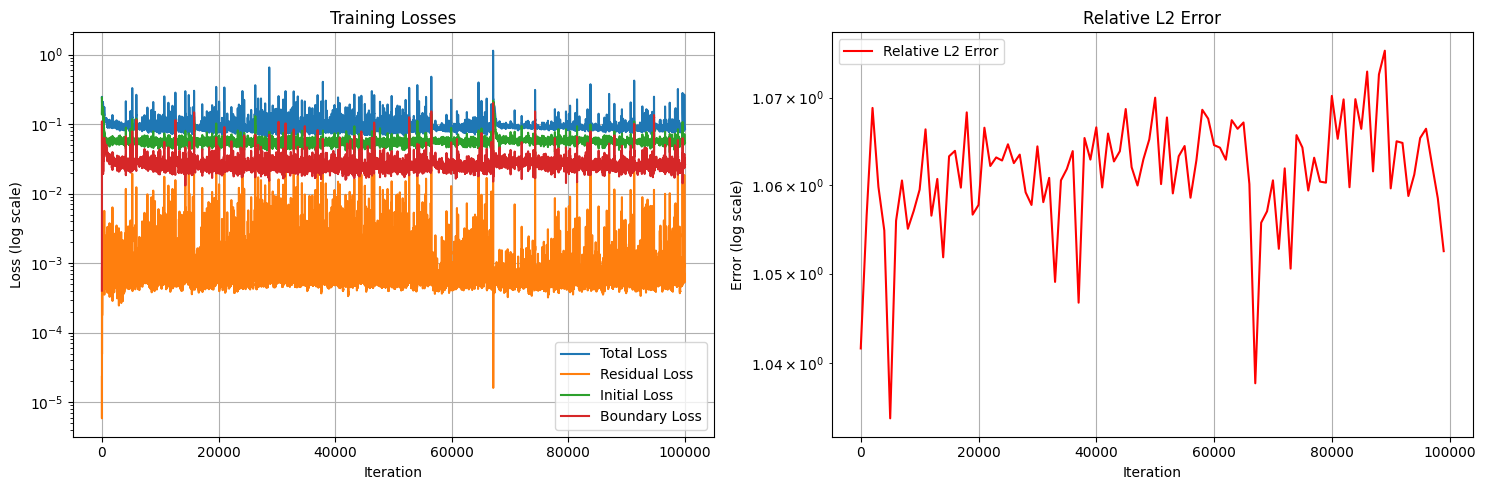

Loss: 8.60e-02 (R: 5.45e-04, I: 5.43e-02, B: 2.62e-02), Error: 1.05e+00: 100%|██████████| 100000/100000 [31:54<00:00, 52.24it/s]



Training completed! Best error: 1.03e+00


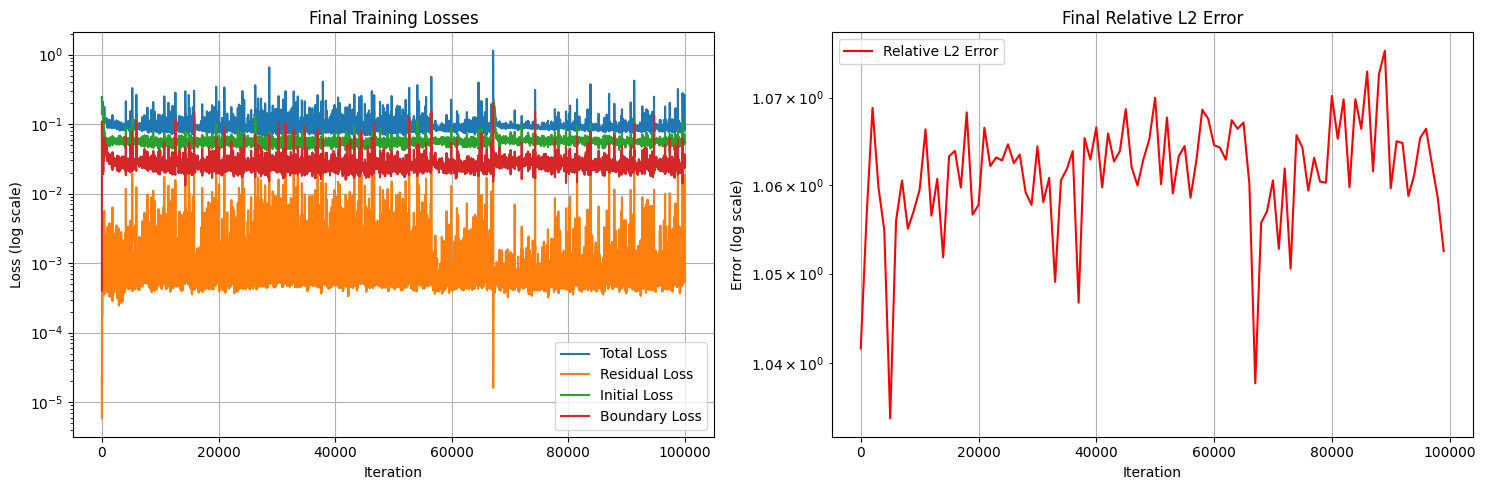

In [7]:
PARAMS = {
    'NC': 1000,        # количество точек коллокации
    'NI': 1000,         # количество начальных точек
    'NB': 1000,         # количество граничных точек
    'NC_TEST': 50,     # количество тестовых точек
    'SEED': 42,        # seed для воспроизводимости
    'LR': 1e-3,        # скорость обучения
    'EPOCHS': 100000,   # количество эпох
    'N_LAYERS': 3,     # количество слоев
    'FEATURES': 64,    # размер признаков
    'LOG_ITER': 1000   # частота логирования
}

error_history = main(**PARAMS)

In [29]:
error_history

[1.0417709350585938,
 1.053159236907959,
 1.0651881694793701,
 1.0576927661895752,
 1.055246114730835,
 1.0553067922592163,
 1.0591237545013428,
 1.0614275932312012,
 1.0555588006973267,
 1.054885745048523,
 1.0618895292282104,
 1.0684521198272705,
 1.0626572370529175,
 1.0646647214889526,
 1.059926986694336,
 1.07772696018219,
 1.059559941291809,
 1.063419222831726,
 1.0712100267410278,
 1.0617653131484985,
 1.0624860525131226,
 1.0720359086990356,
 1.0640459060668945,
 1.0678285360336304,
 1.0634897947311401]